In [1]:
from deepee import (PrivacyWrapper, PrivacyWatchdog, UniformDataLoader,
                     ModelSurgeon, SurgicalProcedures)
import torch
import numpy as np
from torch import nn
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import cv2
from torchvision.transforms import functional as F

class args:
    batch_size = 200
    test_batch_size = 200
    log_interval = 1000
    num_epochs = 5
    device = "cuda" if torch.cuda.is_available() else "cpu"
device = args.device

In [2]:
train_loader = UniformDataLoader(
    
    datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
) 

/Users/helena/.virtualenvs/thesis/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256, track_running_stats=False)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        x = self.bn1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def gaussian_blur(model, kernel):
    model.wrapped_model.fc1.weight.grad = torch.tensor(
        cv2.GaussianBlur(np.array(model.wrapped_model.fc1.weight.grad), kernel, 0)
    )
    model.wrapped_model.fc2.weight.grad = torch.tensor(
        cv2.GaussianBlur(np.array(model.wrapped_model.fc2.weight.grad), kernel, 0)
    )
    model.wrapped_model.fc3.weight.grad = torch.tensor(
        cv2.GaussianBlur(np.array(model.wrapped_model.fc3.weight.grad), kernel, 0)
    )
        
def plot_grad_hist(model, layer, rows, columns, i, title="Gradient histogram", y_lim=7500):
    bins = 50
    x_range = (-0.02, 0.02)
    
    fig.add_subplot(rows, columns, i)
    if layer == 1:
        plt.hist(
            np.transpose(np.array(torch.flatten(model.fc1.weight.grad))), 
            bins=bins, 
            range=x_range
        )
    elif layer == 2:
        plt.hist(
            np.transpose(np.array(torch.flatten(model.fc2.weight.grad))), 
            bins=bins, 
            range=x_range
        )
    elif layer == 3:
        plt.hist(
            np.transpose(np.array(torch.flatten(model.fc3.weight.grad))), 
            bins=bins, 
            range=x_range
        )
    plt.title(title)
    plt.ylim(0, y_lim)
    
def plot_grad_image(model, layer, rows, columns, i, title="Gradient image"):
    fig.add_subplot(rows, columns, i)
    if layer == 1:
        plt.imshow(F.to_pil_image(model.fc1.weight.grad))
    elif layer == 2:
        plt.imshow(F.to_pil_image(model.fc2.weight.grad))
    elif layer == 3:
        plt.imshow(F.to_pil_image(model.fc3.weight.grad))
    plt.title(title)
    plt.axis("off")

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.387936


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 1.8413, Accuracy: 6297/10000 (63%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.836289


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 1.2590, Accuracy: 7368/10000 (74%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.244544


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.8638, Accuracy: 8020/10000 (80%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.817782


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.6273, Accuracy: 8602/10000 (86%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.644633


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.5152, Accuracy: 8823/10000 (88%)


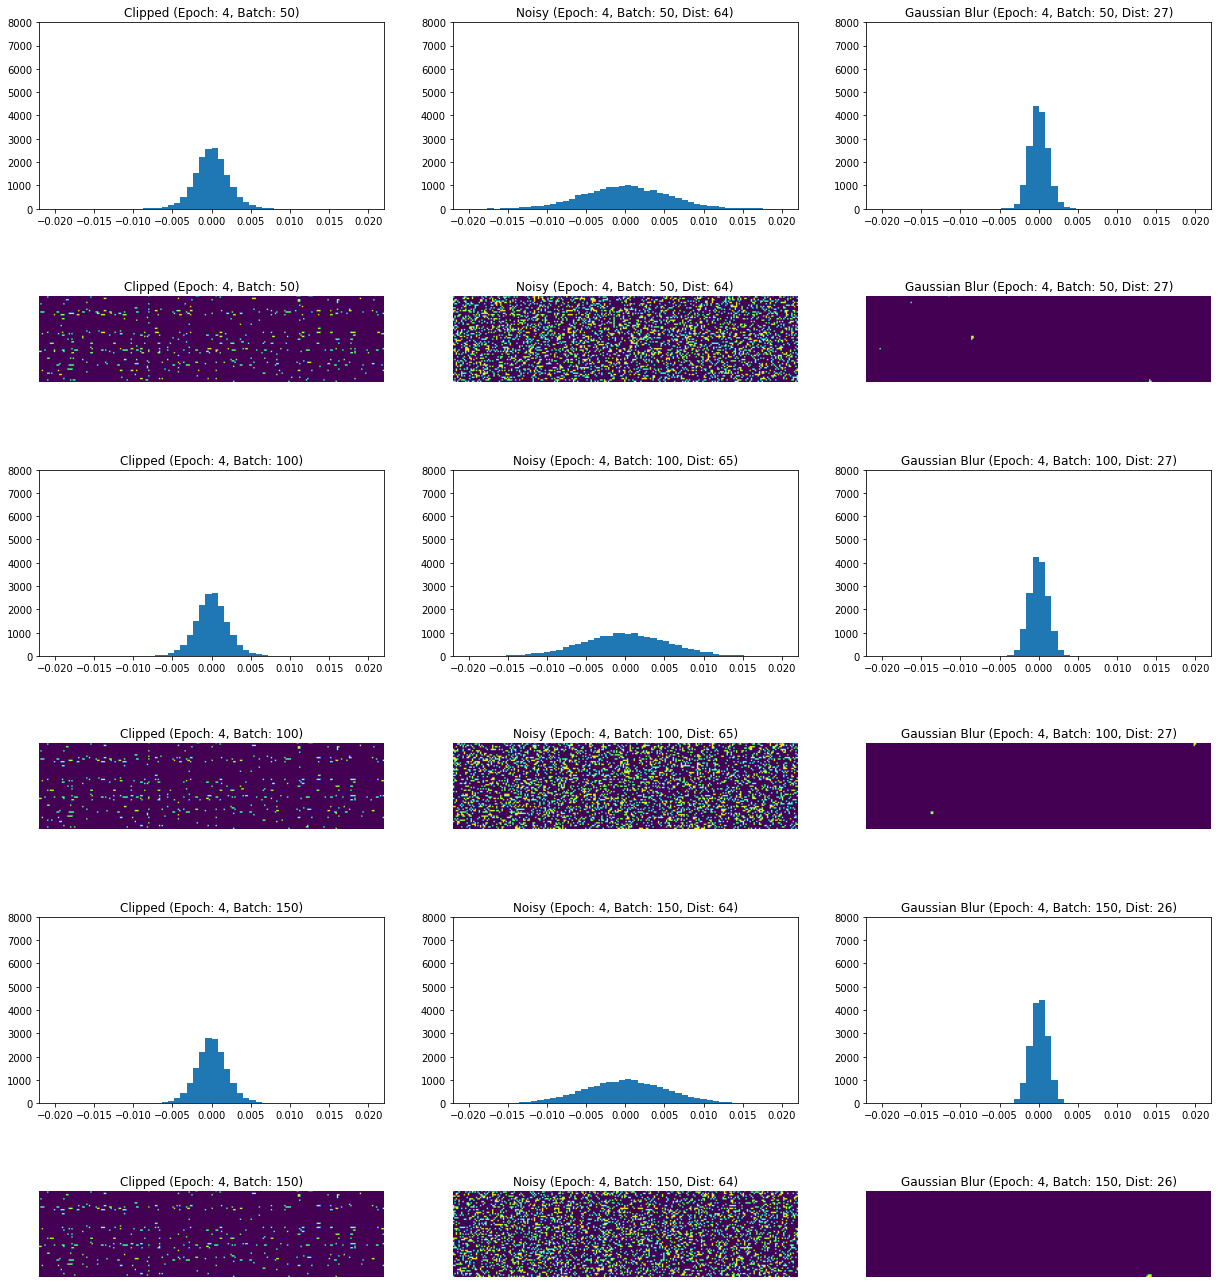

In [5]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

kernel = (7,7)
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            gaussian_blur(model, kernel)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="Gaussian Blur (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            gaussian_blur(model, kernel)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.346569


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 1.6515, Accuracy: 6592/10000 (66%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.649852


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.8892, Accuracy: 8062/10000 (81%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.876972


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.5550, Accuracy: 8720/10000 (87%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.572775


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.4456, Accuracy: 8918/10000 (89%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.420718


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.3757, Accuracy: 9071/10000 (91%)


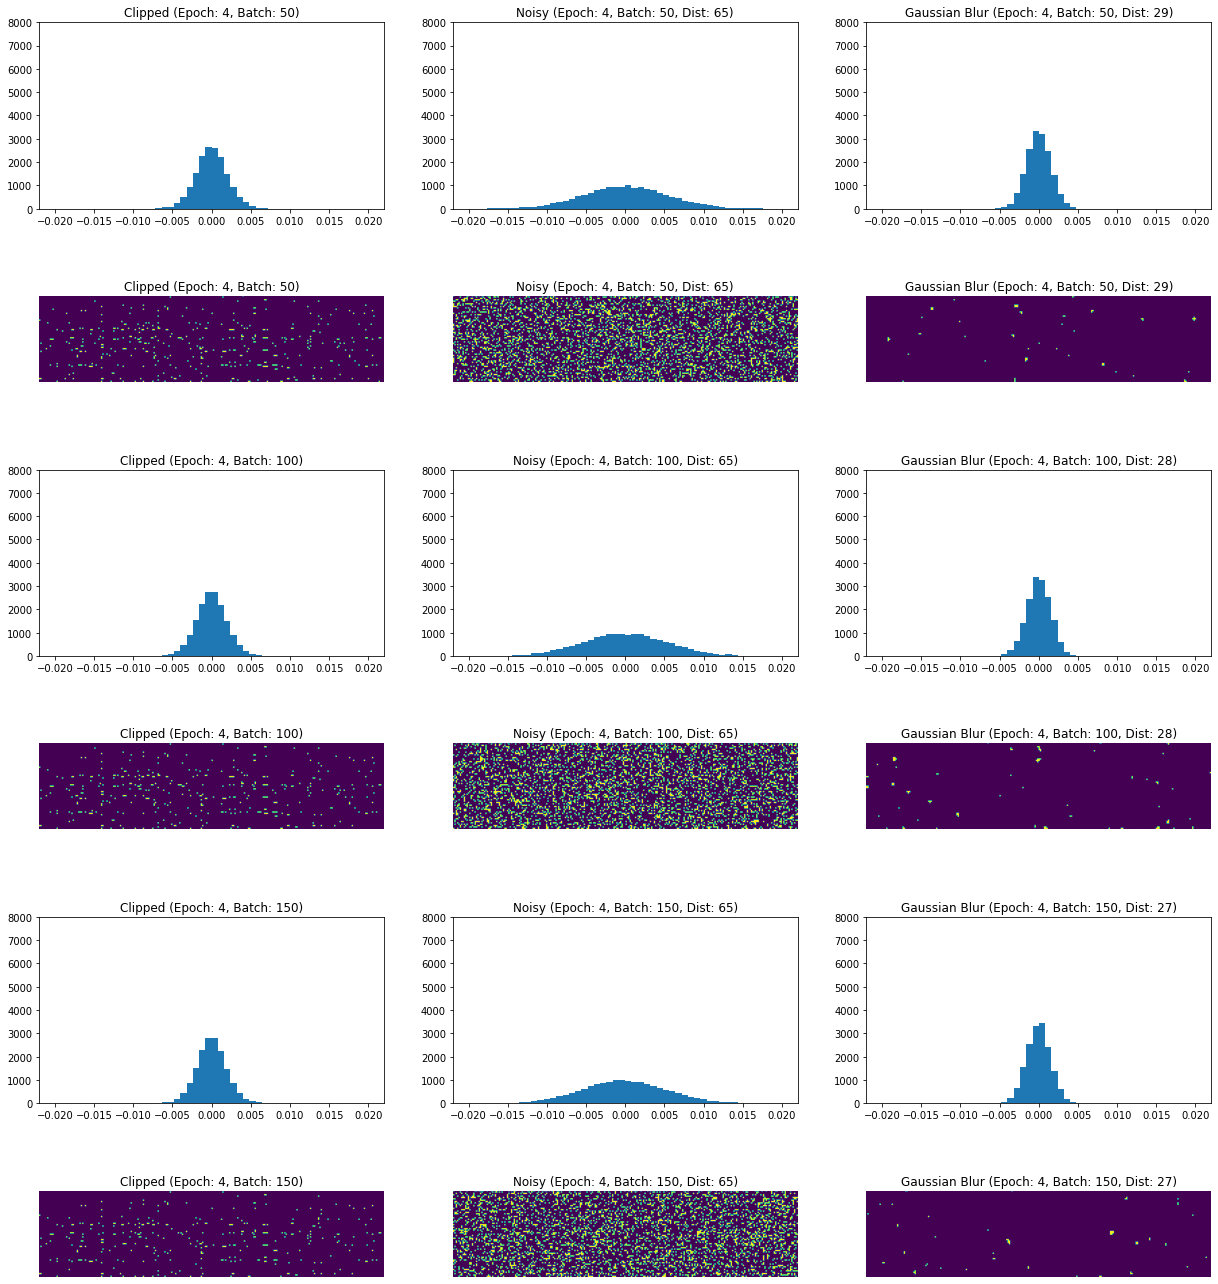

In [6]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

kernel = (5,5)
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            gaussian_blur(model, kernel)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="Gaussian Blur (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            gaussian_blur(model, kernel)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.331814


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 1.3685, Accuracy: 7090/10000 (71%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.279714


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.6583, Accuracy: 8200/10000 (82%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.598807


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.4708, Accuracy: 8724/10000 (87%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.590146


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.4027, Accuracy: 8955/10000 (90%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.446463


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.3513, Accuracy: 9079/10000 (91%)


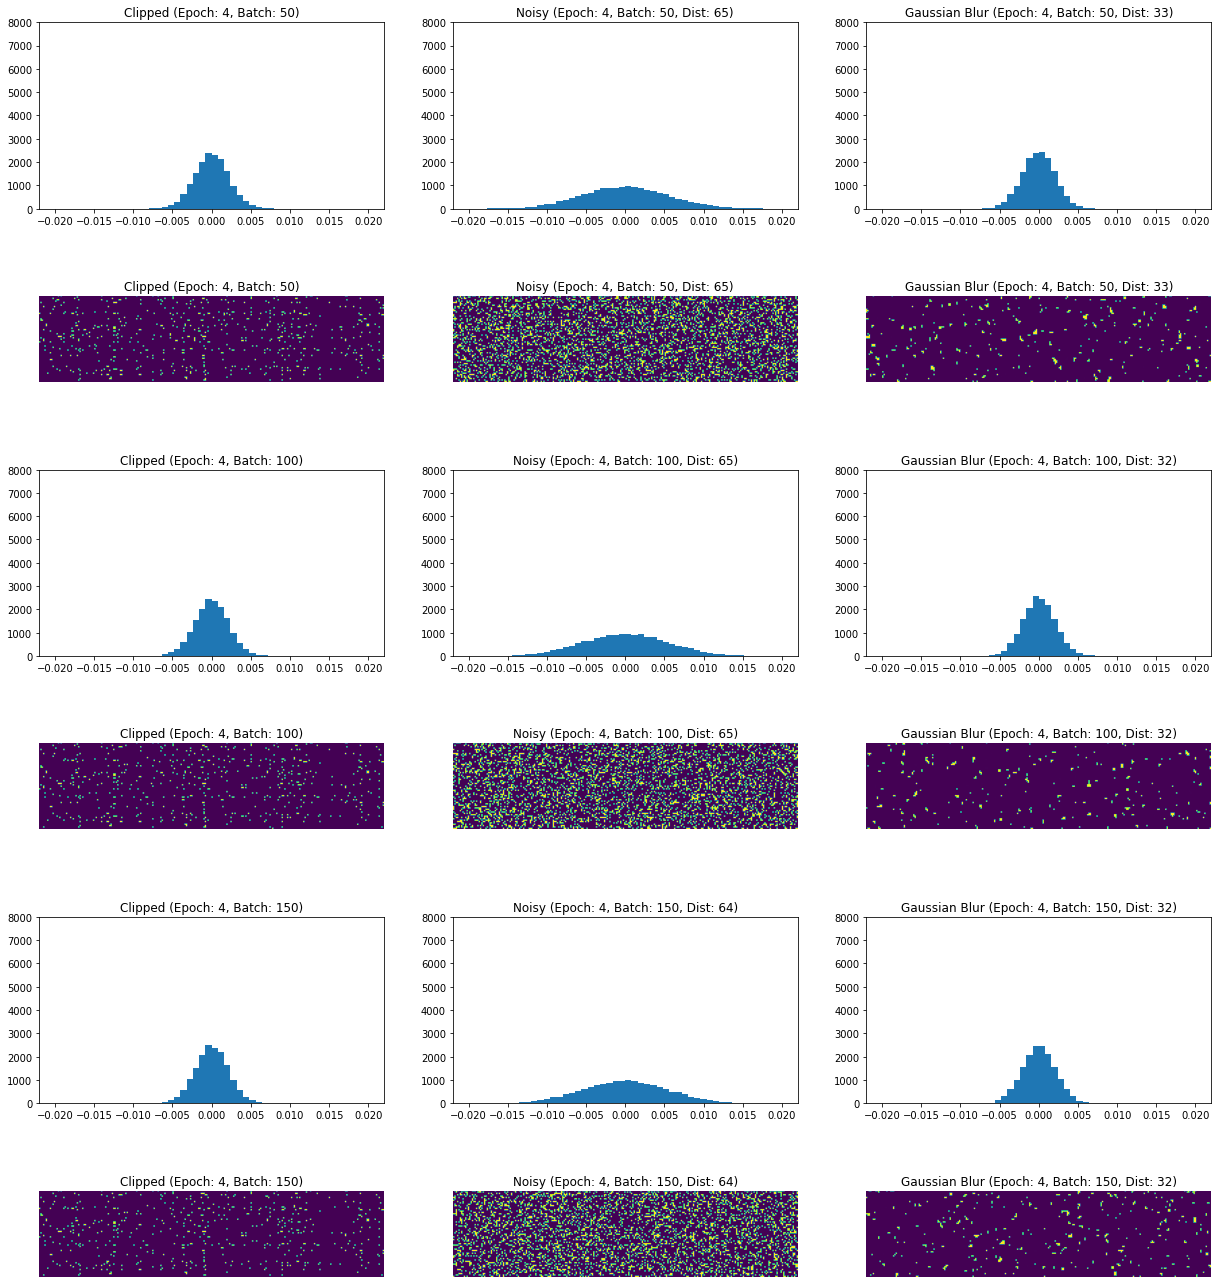

In [7]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

kernel = (3,3)
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            gaussian_blur(model, kernel)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="Gaussian Blur (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            gaussian_blur(model, kernel)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.373604

Test set: Average loss: 0.3725, Accuracy: 9102/10000 (91%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.406705

Test set: Average loss: 0.2867, Accuracy: 9219/10000 (92%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.306404

Test set: Average loss: 0.2481, Accuracy: 9284/10000 (93%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.227682

Test set: Average loss: 0.2163, Accuracy: 9393/10000 (94%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.171981

Test set: Average loss: 0.1877, Accuracy: 9461/10000 (95%)


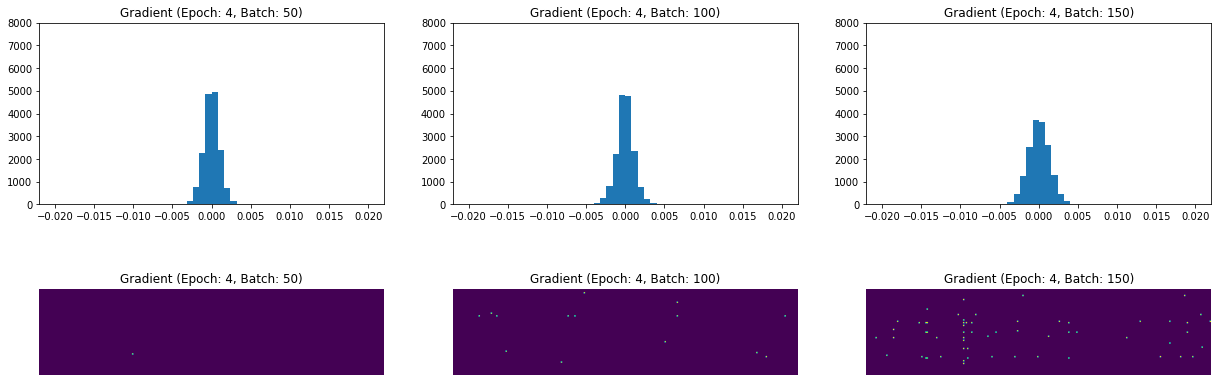

In [9]:
model = SimpleNet().to(args.device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

rows = 50
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            title = "Gradient (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model, 2, rows, columns, i+3, title)
            i = i+1
            
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

In [39]:
def gaussian_blur_flatten(model, kernel):
    size_fc1 = model.wrapped_model.fc1.weight.grad.size()
    model.wrapped_model.fc1.weight.grad = torch.flatten(
        torch.tensor(
            cv2.GaussianBlur(
                np.array(
                    torch.flatten(
                        model.wrapped_model.fc1.weight.grad
                    )
                ), kernel, 0
            )
        )
    ).unflatten(0, size_fc1)
    
    size_fc2 = model.wrapped_model.fc2.weight.grad.size()
    model.wrapped_model.fc2.weight.grad = torch.flatten(
        torch.tensor(
            cv2.GaussianBlur(
                np.array(
                    torch.flatten(
                        model.wrapped_model.fc2.weight.grad
                    )
                ), kernel, 0
            )
        )
    ).unflatten(0, size_fc2)
    
    size_fc3 = model.wrapped_model.fc3.weight.grad.size()
    model.wrapped_model.fc3.weight.grad = torch.flatten(
        torch.tensor(
            cv2.GaussianBlur(
                np.array(
                    torch.flatten(
                        model.wrapped_model.fc3.weight.grad
                    )
                ), kernel, 0
            )
        )
    ).unflatten(0, size_fc3)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.440699


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 1.0946, Accuracy: 7123/10000 (71%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.121582


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.4544, Accuracy: 8737/10000 (87%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.498319


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.4206, Accuracy: 8991/10000 (90%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.489206


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.3946, Accuracy: 9085/10000 (91%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.642300


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.3377, Accuracy: 9188/10000 (92%)


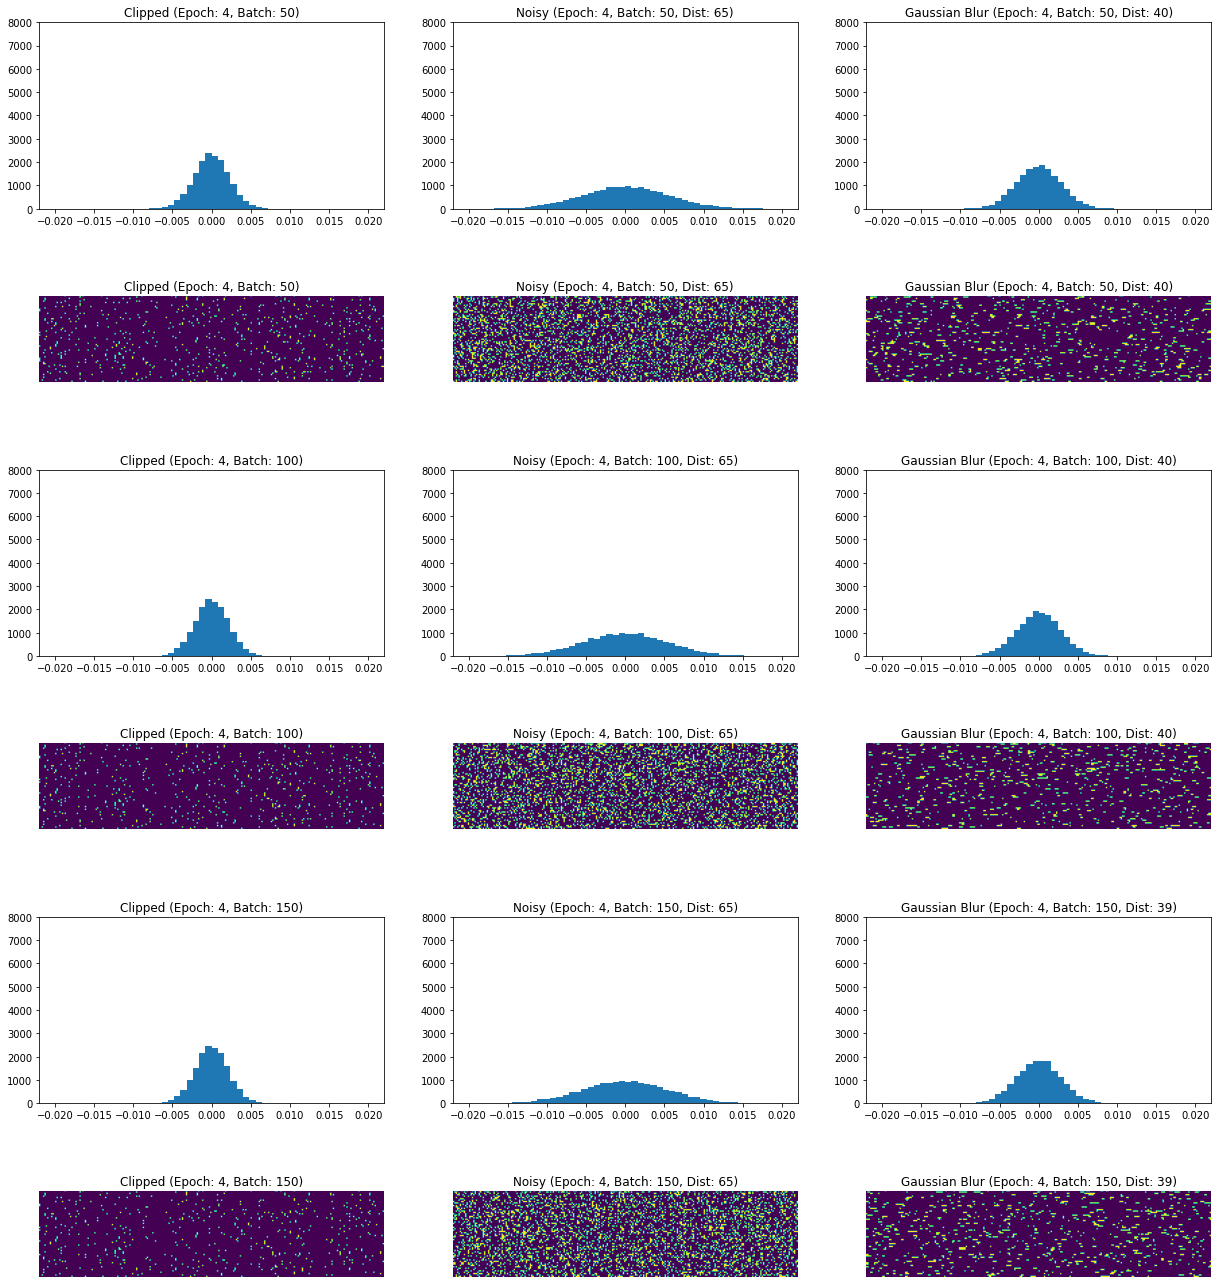

In [52]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

kernel = (1,5)
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            gaussian_blur_flatten(model, kernel)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="Gaussian Blur (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            gaussian_blur_flatten(model, kernel)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.346267


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 1.7028, Accuracy: 6185/10000 (62%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.715348


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 1.0595, Accuracy: 7479/10000 (75%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.085285


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.7033, Accuracy: 8028/10000 (80%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.687125


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.4786, Accuracy: 8656/10000 (87%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.504041


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.3762, Accuracy: 8945/10000 (89%)


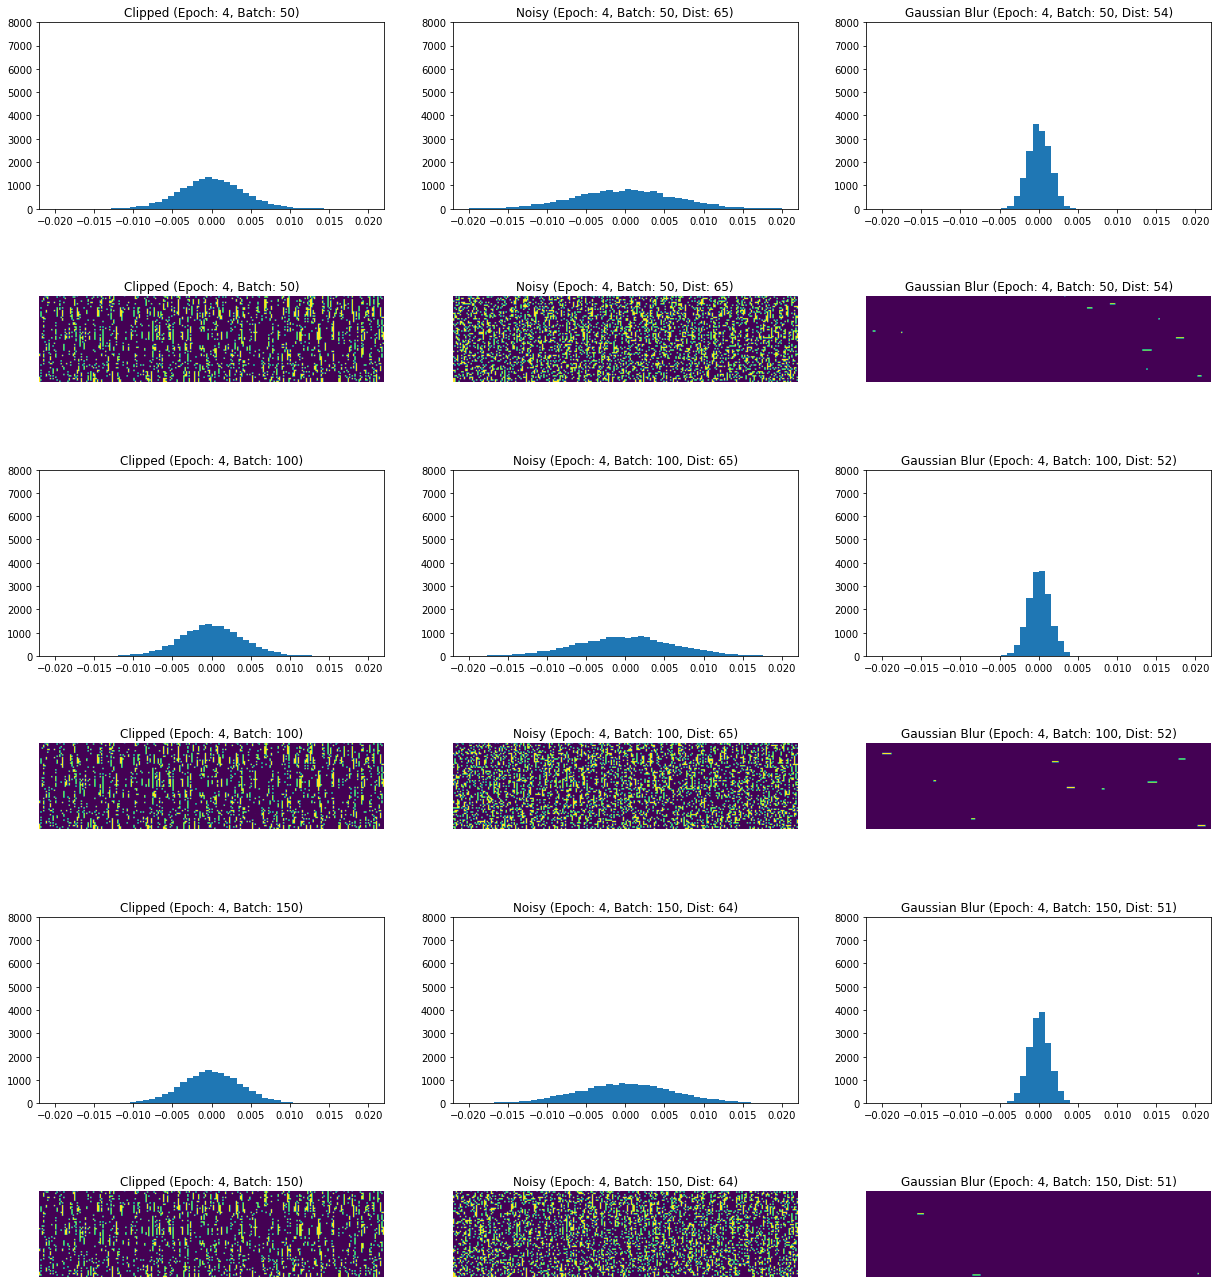

In [42]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

kernel = (1,25)
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            gaussian_blur_flatten(model, kernel)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="Gaussian Blur (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            gaussian_blur_flatten(model, kernel)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.316138


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 1.2640, Accuracy: 7655/10000 (77%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.263779


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.5125, Accuracy: 8612/10000 (86%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.511842


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.4149, Accuracy: 8903/10000 (89%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.353490


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.3746, Accuracy: 9082/10000 (91%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.406890


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.3270, Accuracy: 9175/10000 (92%)


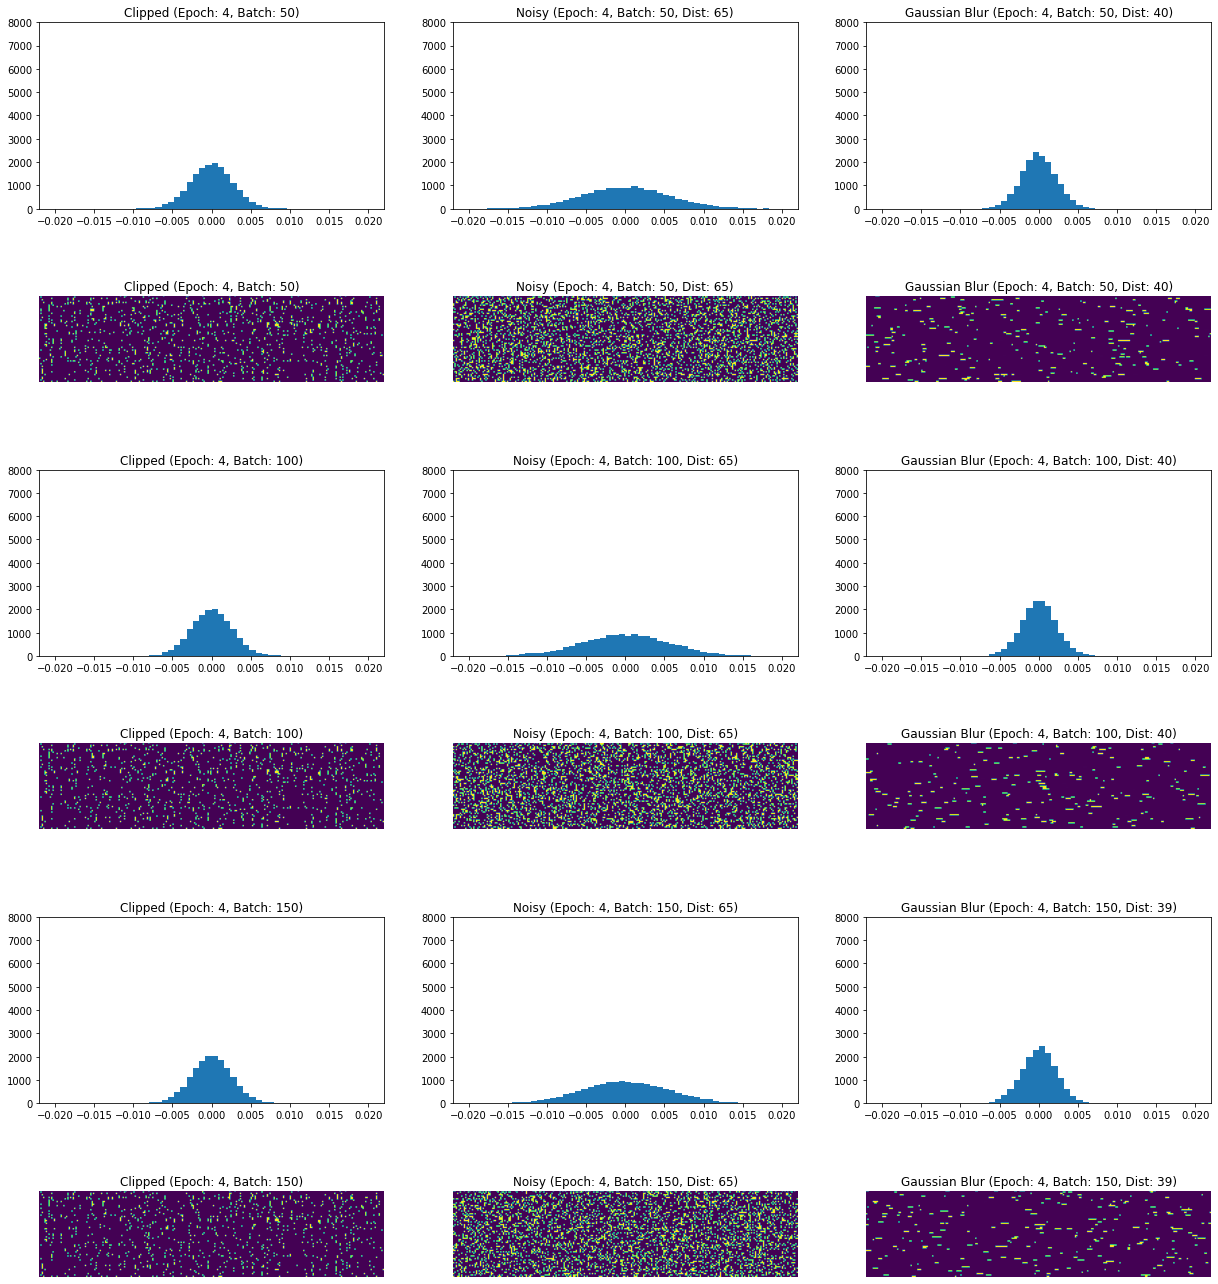

In [53]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

kernel = (1,9)
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            gaussian_blur_flatten(model, kernel)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="Gaussian Blur (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            gaussian_blur_flatten(model, kernel)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.353691


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 1.4291, Accuracy: 6964/10000 (70%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.454895


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.6549, Accuracy: 8229/10000 (82%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.646738


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.4547, Accuracy: 8717/10000 (87%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.442932


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.3801, Accuracy: 8977/10000 (90%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.498901


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.3372, Accuracy: 9106/10000 (91%)


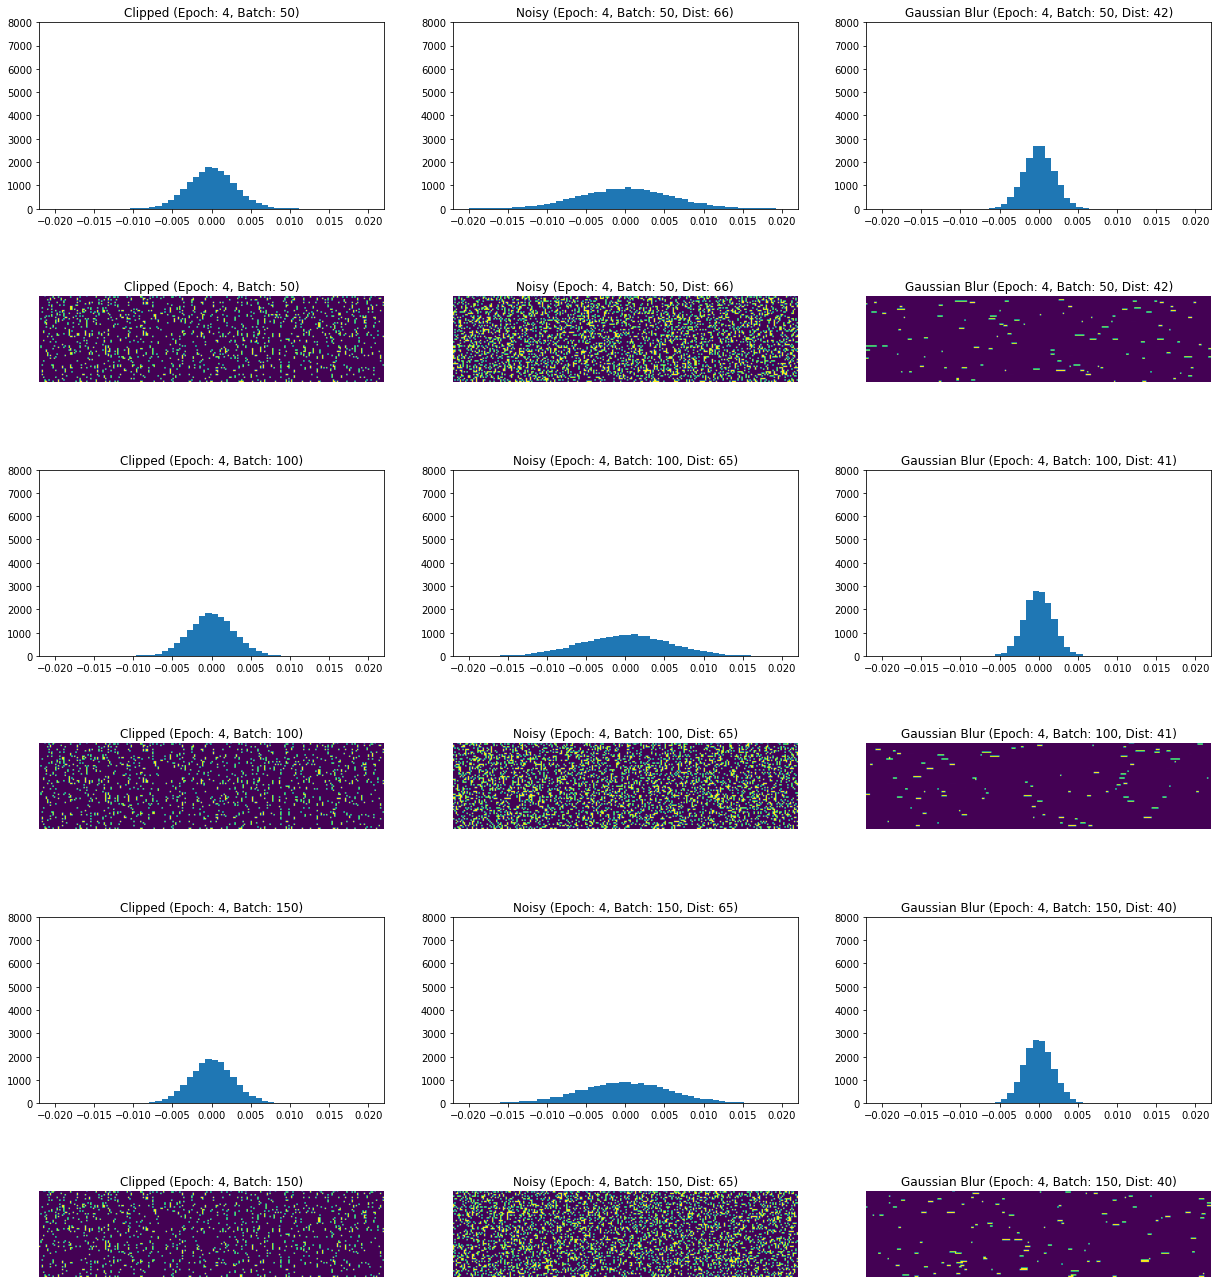

In [54]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

kernel = (1,13)
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            gaussian_blur_flatten(model, kernel)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="Gaussian Blur (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            gaussian_blur_flatten(model, kernel)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.354664


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 0.9356, Accuracy: 7651/10000 (77%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.976480


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.4355, Accuracy: 8844/10000 (88%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.394165


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.3987, Accuracy: 9067/10000 (91%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.189824


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.3610, Accuracy: 9129/10000 (91%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.380309


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.3112, Accuracy: 9203/10000 (92%)


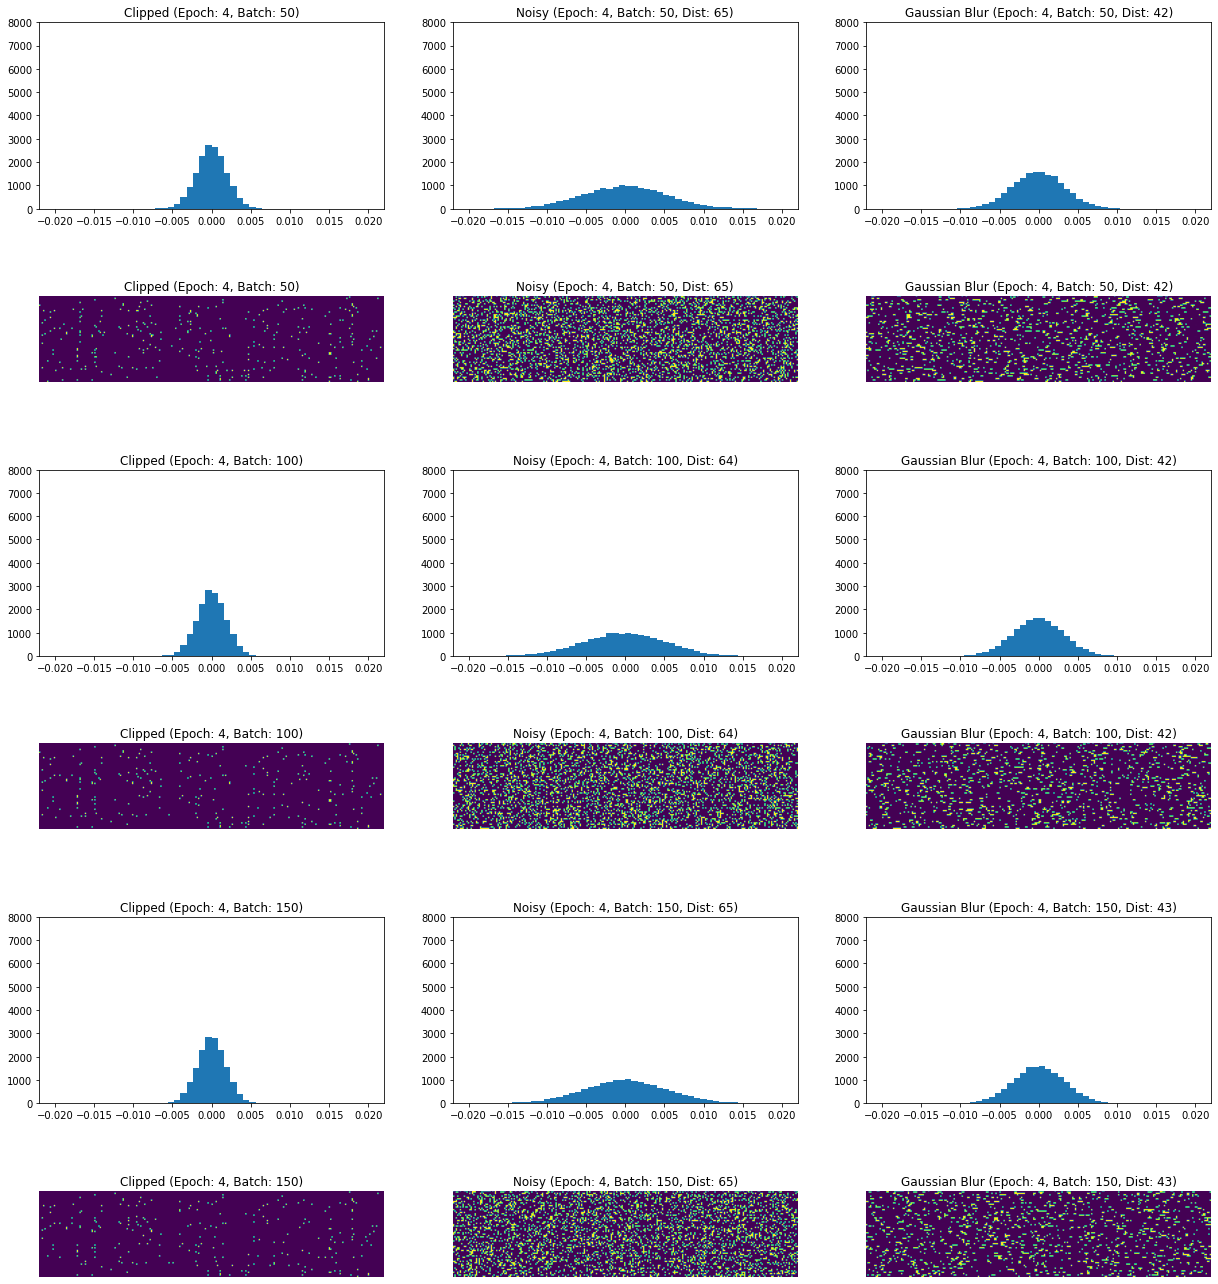

In [55]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

kernel = (1,3)
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            gaussian_blur_flatten(model, kernel)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="Gaussian Blur (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            gaussian_blur_flatten(model, kernel)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

In [62]:
torch.tensor(
    cv2.GaussianBlur(
        np.array(
            torch.flatten(
                model.wrapped_model.fc1.weight.grad
            )
        ), (1,5), 0
    )
).unflatten(0, size_fc1).size()

torch.Size([256, 784, 1])